In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib
import nltk
import re
import tensorflow as tf
import torch
import torchtext

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential 
from keras.layers import Flatten, Dense, Embedding
from keras.initializers import Constant

2023-06-25 16:45:57.141611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Applications/anaconda3/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
train_df = pd.read_csv('data/twitter_training.csv', header=None, 
                       names=['tweet_id', 'entity', 'sentiment', 'tweet_content'])
test_df = pd.read_csv('data/twitter_validation.csv', header=None, 
                       names=['tweet_id', 'entity', 'sentiment', 'tweet_content'])

# 1. Data exploration

## train_df

In [3]:
for col in train_df:
    print(col, ':', len(train_df[col].unique()))

tweet_id : 12447
entity : 32
sentiment : 4
tweet_content : 69492


In [4]:
# Drop NAs
print(train_df.isnull().sum(axis=0))
train_df = train_df.dropna(axis=0)

tweet_id           0
entity             0
sentiment          0
tweet_content    686
dtype: int64


In [5]:
# idk what's going on but only take the first of each tweet_id
train_df = train_df.groupby('tweet_id', as_index = True).first()

<AxesSubplot:xlabel='sentiment', ylabel='Count'>

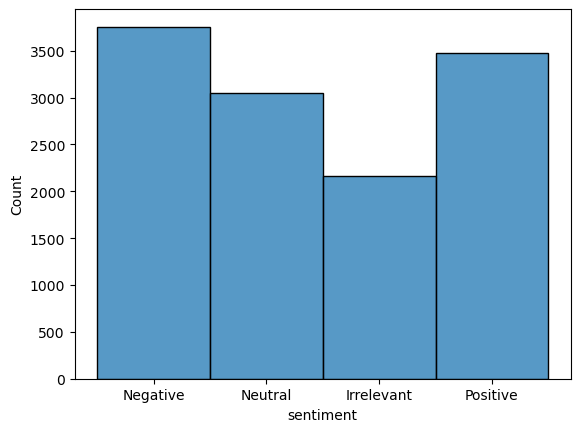

In [6]:
# histplot of sentiment
seaborn.histplot(train_df.sentiment)

## test_df

In [7]:
for col in test_df:
    print(col, ':', len(test_df[col].unique()))

tweet_id : 1000
entity : 32
sentiment : 4
tweet_content : 999


In [8]:
# Drop NAs
print(test_df.isnull().sum(axis=0))

tweet_id         0
entity           0
sentiment        0
tweet_content    0
dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='Count'>

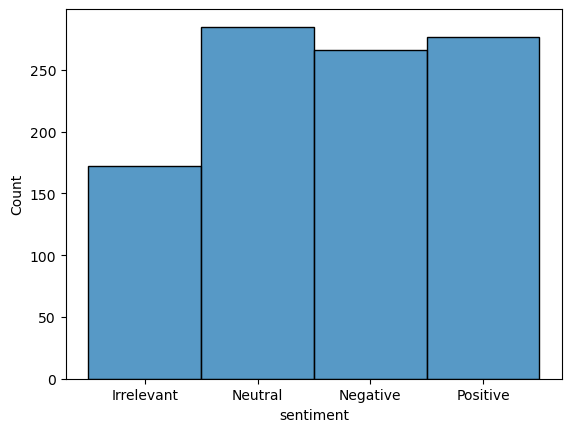

In [9]:
# histplot of sentiment
seaborn.histplot(test_df.sentiment)

# Text Processing
1. Lowercasing
2. Remove all punctuation except for apostrophes
3. Whitespace tokenisation
4. Removing stopwords
5. Removing words with numbers (numbers, usernames etc.)
6. POS tagging
7. Lemmatisation

(find size of vocabulary after processing, one hot encode each tweet for final vocab)

In [10]:
# getting stopwords
stopwords = stopwords.words('english')

# POS tagging and lemmatisation
#nltk.download('averaged_perceptron_tagger')  # Download POS tagger data
#nltk.download('wordnet')

In [11]:
# function to convert POS tags to wordnet tags
def convert_pos_tag(tag):
    """ 
    Takes in POS tags to POS tags that are used by wordnet (for lemmatisation)
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [12]:
# function to pre-process text df
def preprocess_text(tweet_df, stopword_list, remove_apostrophes):
    """
    Takes in df of tweets in str form, indexed by tweet_id, and returns dictionary of tweets processed:
        1. lowercasing
        2. remove punctuation except for apostrophes
        3. whitespace tokenisation
        4. remove stopwords
        5. remove numbers and words with numbers
        6. POS tagging
        7. lemmatisation

    :param tweet_df: df of tweets, indexed by tweet_id, tweet_content is a string
    :param stopword_list: preloaded list of stopwords
    :param remove_apostrophes: bool value indicating if we want to remove apostrophes
    """
    
    # dictionary to store all tokens
    tweet_dict = {tweet_id: None for tweet_id in tweet_df.index}
    
    for tweet_id in tweet_dict.keys():
        # extract text
        tweet = tweet_df.loc[tweet_id]['tweet_content']
        
        # lowercasing
        tweet = tweet.lower()

        # remove all punctuation 
        if remove_apostrophes:
            tweet = re.sub(r'[^\w\d\s]+', ' ', tweet)
        else:
            tweet = re.sub(r'[^\w\d\s\']+', ' ', tweet)
        
        # whitespace tokenisation
        tweet_tokens = nltk.WhitespaceTokenizer().tokenize(tweet)
        
        # removing stopwords
        tweet_tokens = [word for word in tweet_tokens if word not in stopword_list]

        # remove any words with numbers in them
        tweet_tokens = [token for token in tweet_tokens if not re.match(r'.*\d.*', token)]

        # POS tagging and convert to wordnet tags
        tagged_tweet_tokens = nltk.pos_tag(tweet_tokens)

        # Lemmatisation
        lemmatizer = WordNetLemmatizer()
        lemmas = []
        for token, pos_tag in tagged_tweet_tokens:
            wn_pos = convert_pos_tag(pos_tag)
            if wn_pos is not None:
                lemma = lemmatizer.lemmatize(token, pos=wn_pos)
            else:
                lemma = lemmatizer.lemmatize(token)
            
            lemmas.append(lemma)

        # update tweet dictionary
        tweet_dict[tweet_id] = lemmas

    return tweet_dict

In [13]:
# function to find vocabulary, vocabulary size and max tweet size (train_df + test_df)
def find_vocab(tweet_dict_list):
    """ 
    Takes in a list of tweet dictionaries to find total vocabulary size 
    and max tweet size (for padding)
    """
    # store
    vocabulary = set()
    max_tweet_size = 0

    for dict in tweet_dict_list:
        for tokens in dict.values():
            # vocabulary
            vocabulary.update(tokens)

            # finding max tweet size for padding
            if len(tokens) > max_tweet_size:
                max_tweet_size = len(tokens)

    vocab_size = len(vocabulary)
    print('Vocabulary size: ', vocab_size)
    print('Max tweet size: ', max_tweet_size)
    
    return vocabulary, vocab_size, max_tweet_size

## Preprocess type 1
for training our own embeddings

In [14]:
# preprocess train_df and test_df
train_text_dict = preprocess_text(train_df, stopwords, False)
test_text_dict = preprocess_text(test_df, stopwords, False)

In [15]:
# find dimensions for embedding
vocab, vocab_size, max_tweet_size = find_vocab([train_text_dict, test_text_dict])

Vocabulary size:  17021
Max tweet size:  43


## Preprocess type 2
For pretrained GloVe embeddings

In [16]:
# preprocess train_df and test_df
train_text_dict_2 = preprocess_text(train_df, stopwords, True)
test_text_dict_2 = preprocess_text(test_df, stopwords, True)

In [17]:
# find dimensions for embedding
vocab_2, vocab_size_2, max_tweet_size_2 = find_vocab([train_text_dict_2, test_text_dict_2])

Vocabulary size:  16689
Max tweet size:  43


# Model 1
Neural network with layers:
1. Embedding layer - trained with our train + test vocabulary
2. Flatten layer
3. Dense with softmax activation

## Model building

In [18]:
# function to one hot encode using Keras, pad all tweets to same size
def one_hot_pad(tweet_dict, vocab_size, max_tweet_size):
    """ 
    Given a tweet_dict, one hot encode all tweets using given vocab size, and pad to 
    uniform length, return updated dictionary
    """
    tweet_dict_encoded = {}

    for tweet_id, tweet_lemma in tweet_dict.items():
        encoded = [one_hot(token, vocab_size) for token in tweet_lemma]
        encoded_flat = [enc_token for token in encoded for enc_token in token] # flatten list
        encoded_flat.extend([0]* (max_tweet_size - len(encoded_flat))) # padding
        tweet_dict_encoded[tweet_id] = encoded_flat

    return tweet_dict_encoded

In [19]:
# train and test dictionaries
train_dict = one_hot_pad(train_text_dict, vocab_size, max_tweet_size)
test_dict = one_hot_pad(test_text_dict, vocab_size, max_tweet_size)

In [20]:
# create Keras model and add layers

# define the model
model = Sequential()
model.add(Embedding(input_dim = vocab_size, 
                    output_dim = 100, 
                    input_length = max_tweet_size))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

# compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 100)           1702100   
                                                                 
 flatten (Flatten)           (None, 4300)              0         
                                                                 
 dense (Dense)               (None, 4)                 17204     
                                                                 
Total params: 1,719,304
Trainable params: 1,719,304
Non-trainable params: 0
_________________________________________________________________
None


2023-06-25 16:46:53.088378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Model fitting

In [21]:
# reshape training data
train_x_df = pd.DataFrame.from_dict(train_dict, orient='index')
train_y_df = pd.get_dummies(train_df.sentiment)

In [42]:
# Training the model
model.fit(x=train_x_df, y=train_y_df, epochs=50, verbose=1)

Epoch 1/50
389/389 [==============================] - 10s 25ms/step - loss: 0.1034 - categorical_accuracy: 0.9716
Epoch 2/50
389/389 [==============================] - 11s 27ms/step - loss: 0.0809 - categorical_accuracy: 0.9763
Epoch 3/50
389/389 [==============================] - 10s 26ms/step - loss: 0.0714 - categorical_accuracy: 0.9768
Epoch 4/50
389/389 [==============================] - 10s 26ms/step - loss: 0.0651 - categorical_accuracy: 0.9781
Epoch 5/50
389/389 [==============================] - 10s 25ms/step - loss: 0.0614 - categorical_accuracy: 0.9781
Epoch 6/50
389/389 [==============================] - 17s 43ms/step - loss: 0.0574 - categorical_accuracy: 0.9795
Epoch 7/50
389/389 [==============================] - 13s 33ms/step - loss: 0.0543 - categorical_accuracy: 0.9796
Epoch 8/50
389/389 [==============================] - 12s 31ms/step - loss: 0.0521 - categorical_accuracy: 0.9801
Epoch 9/50
389/389 [==============================] - 9s 22ms/step - loss: 0.0513 - cate

## Model prediction

In [23]:
# reshape testing data
test_x_df = pd.DataFrame.from_dict(test_dict, orient='index')
test_y_df = pd.get_dummies(test_df.sentiment)

In [43]:
# Prediction and evaluation
loss, accuracy = model.evaluate(test_x_df, test_y_df, verbose=1)


32/32 [==============================] - 0s 3ms/step - loss: 0.2246 - categorical_accuracy: 0.9650


# Model 2
Neural network with layers:
1. Pretrained embedding layer (GloVe)
2. Flatten
3. Dense with softmax activation

### Preparing embedding matrix

In [25]:
# loading GloVe dataset
path_to_glove = 'glove.6b.100d.txt'
glove_embeddings = {}
with open(path_to_glove) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs


In [26]:
# Index vocabulary
vocab_index = list(range(2, vocab_size_2 + 2))
indexed_vocab = {word:index for word, index in zip(vocab_2, vocab_index)}

In [27]:
# function to pad and index our dictionaries of tweets
def index_tweets(tweet_dict, max_tweet_size):
    indexed_dict = {}
    for tweet_id, tweet in tweet_dict.items():
    # storing index of every word in each tweet
        tweet_indexed = []
        for word in tweet:
            word_index = indexed_vocab[word]
            tweet_indexed.append(word_index)
        # store tweet indexes
        indexed_dict[tweet_id] = tweet_indexed

        # pad tweet here
        pad_amount = max_tweet_size - len(tweet_indexed)
        if pad_amount > 0:
            tweet_indexed.extend([0]* pad_amount) # padding
    
    return indexed_dict


In [28]:
# index train and test dictionaries
train_indexed_dict = index_tweets(train_text_dict_2, max_tweet_size_2)
test_indexed_dict = index_tweets(test_text_dict_2, max_tweet_size_2)

In [29]:
# Preparing our embedding matrix (according to our vocabulary index)
hits = 0
misses = 0

# create embedding matrix for our vocabulary
embedding_matrix = np.zeros((vocab_size_2 + 2, 100))
hits = 0
misses = 0

for word, word_index in indexed_vocab.items():
    word_embedding = glove_embeddings.get(word)
    if word_embedding is not None:
        embedding_matrix[word_index] = word_embedding
        hits += 1
    else:
        misses += 1

print('hits: ', hits)
print('misses: ', misses)

hits:  11274
misses:  5415


## Model building

In [31]:
# create Keras model and add layers

# define the model
model2 = Sequential()
model2.add(Embedding(input_dim = vocab_size_2 + 2,
                     output_dim = 100,
                     input_length = max_tweet_size_2,
                     embeddings_initializer=Constant(embedding_matrix),
                     trainable=False))
model2.add(Flatten())
model2.add(Dense(4, activation='softmax'))

# compile the model
model2.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

# summarize the model
print(model2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 43, 100)           1669100   
                                                                 
 flatten_1 (Flatten)         (None, 4300)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 17204     
                                                                 
Total params: 1,686,304
Trainable params: 17,204
Non-trainable params: 1,669,100
_________________________________________________________________
None


## Model Fitting

In [33]:
# reshape training data
train_x_df_2 = pd.DataFrame.from_dict(train_indexed_dict, orient='index')
#train_y_df = pd.get_dummies(train_df.sentiment)

In [36]:
# fitting the model
model2.fit(x=train_x_df_2, y=train_y_df, epochs=50, verbose=1)

Epoch 1/50
389/389 [==============================] - 2s 6ms/step - loss: 0.9009 - categorical_accuracy: 0.6348
Epoch 2/50
389/389 [==============================] - 2s 6ms/step - loss: 0.8958 - categorical_accuracy: 0.6405
Epoch 3/50
389/389 [==============================] - 2s 4ms/step - loss: 0.8872 - categorical_accuracy: 0.6402
Epoch 4/50
389/389 [==============================] - 1s 3ms/step - loss: 0.8803 - categorical_accuracy: 0.6463
Epoch 5/50
389/389 [==============================] - 1s 3ms/step - loss: 0.8757 - categorical_accuracy: 0.6461
Epoch 6/50
389/389 [==============================] - 1s 4ms/step - loss: 0.8702 - categorical_accuracy: 0.6500
Epoch 7/50
389/389 [==============================] - 2s 4ms/step - loss: 0.8650 - categorical_accuracy: 0.6541
Epoch 8/50
389/389 [==============================] - 1s 3ms/step - loss: 0.8592 - categorical_accuracy: 0.6563
Epoch 9/50
389/389 [==============================] - 1s 4ms/step - loss: 0.8558 - categorical_accuracy:

## Model prediction

In [37]:
# reshape testing data
test_x_df_2 = pd.DataFrame.from_dict(test_indexed_dict, orient='index')


In [38]:
# Prediction and evaluation
loss2, accuracy2 = model2.evaluate(test_x_df_2, test_y_df, verbose=1)

32/32 [==============================] - 1s 8ms/step - loss: 1.0662 - categorical_accuracy: 0.6720


# Model 2.1
Allow for fine-tuning with GloVe embeddings

## Model building

In [39]:
# create Keras model and add layers

# define the model
model21 = Sequential()
model21.add(Embedding(input_dim = vocab_size_2 + 2,
                     output_dim = 100,
                     input_length = max_tweet_size_2,
                     embeddings_initializer=Constant(embedding_matrix),
                     trainable=True))
model21.add(Flatten())
model21.add(Dense(4, activation='softmax'))

# compile the model
model21.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

# summarize the model
print(model21.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 43, 100)           1669100   
                                                                 
 flatten_2 (Flatten)         (None, 4300)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 17204     
                                                                 
Total params: 1,686,304
Trainable params: 1,686,304
Non-trainable params: 0
_________________________________________________________________
None


## Model fitting

In [40]:
# fitting the model
model21.fit(x=train_x_df_2, y=train_y_df, epochs=50, verbose=1)

Epoch 1/50
389/389 [==============================] - 13s 29ms/step - loss: 1.2358 - categorical_accuracy: 0.4583
Epoch 2/50
389/389 [==============================] - 14s 35ms/step - loss: 0.9588 - categorical_accuracy: 0.6165
Epoch 3/50
389/389 [==============================] - 10s 26ms/step - loss: 0.7542 - categorical_accuracy: 0.7173
Epoch 4/50
389/389 [==============================] - 10s 24ms/step - loss: 0.5782 - categorical_accuracy: 0.8007
Epoch 5/50
389/389 [==============================] - 10s 26ms/step - loss: 0.4401 - categorical_accuracy: 0.8641
Epoch 6/50
389/389 [==============================] - 10s 25ms/step - loss: 0.3382 - categorical_accuracy: 0.9007
Epoch 7/50
389/389 [==============================] - 11s 27ms/step - loss: 0.2641 - categorical_accuracy: 0.9234
Epoch 8/50
389/389 [==============================] - 13s 34ms/step - loss: 0.2111 - categorical_accuracy: 0.9401
Epoch 9/50
389/389 [==============================] - 12s 32ms/step - loss: 0.1721 - cat

## Model prediction

In [41]:
loss21, accuracy21 = model21.evaluate(test_x_df_2, test_y_df, verbose=1)

32/32 [==============================] - 1s 12ms/step - loss: 0.1491 - categorical_accuracy: 0.9750


# Model 3?
Pretrained embedding input matrix, classification model 
(Random Forest, SVM, etc.) -> compare all the models, try stacked model